In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

In [23]:
print("\n" + "=" * 70)
print("STEP 1 (REVISED): DATA PREPARATION")
print("=" * 70)

# Load the data
data_path = Path(r'D:\code\SEG\data\silver\zillow\home_values\wide.parquet')
df = pd.read_parquet(data_path)

print(f"\n📊 Raw data loaded: {df.shape}")

# Step 1.1: Filter to state-level, all homes, ALL bedrooms
state_data = df[
    (df['Region Type'] == 4) &      # State level
    (df['Home Type'] == 3) &         # All homes
    (df['Bedroom Count'] == 5)       # 5 = All Bedrooms (aggregate)
].copy()

print(f"\n✓ Filtered to states, all homes, all bedrooms: {state_data.shape}")
print(f"  Unique states: {state_data['State'].nunique()}")

# Step 1.2: Convert timestamp and select columns
state_data['date'] = pd.to_datetime(state_data['Date'], unit='ms')
state_data = state_data[['State', 'date', 'Mid Tier ZHVI (Smoothed) (Seasonally Adjusted)']].copy()
state_data.columns = ['State', 'Date', 'ZHVI']

# Step 1.3: Include 2017 data for YoY calculation
state_data = state_data[state_data['Date'] >= '2017-01-01'].copy()
state_data = state_data.sort_values(['State', 'Date']).reset_index(drop=True)

print(f"\n✓ Loaded data from 2017+ (for YoY calculation): {state_data.shape}")
print(f"  Date range: {state_data['Date'].min()} to {state_data['Date'].max()}")

# Step 1.4: Calculate YoY percentage change
state_data['ZHVI_12mo_ago'] = state_data.groupby('State')['ZHVI'].shift(12)
state_data['Price_YoY'] = (state_data['ZHVI'] / state_data['ZHVI_12mo_ago']) - 1

# Step 1.5: Filter to 2018+ for analysis (now with complete YoY data)
analysis_data = state_data[
    (state_data['Date'] >= '2018-01-01') & 
    (state_data['Price_YoY'].notna())
][['State', 'Date', 'Price_YoY']].copy()

print(f"\n✓ Calculated YoY price growth")
print(f"  Analysis dataset: {analysis_data.shape}")
print(f"  Analysis period: {analysis_data['Date'].min()} to {analysis_data['Date'].max()}")
print(f"  States included: {analysis_data['State'].nunique()}")

# Show sample
print(f"\n📋 Sample Data:")
print(analysis_data.head(10))

# Summary stats
print(f"\n📊 YoY Price Growth Summary:")
print(analysis_data['Price_YoY'].describe().apply(lambda x: f"{x*100:.2f}%"))

print("\n" + "=" * 70)
print("✅ STEP 1 COMPLETE - Data ready for correlation analysis")
print("=" * 70)


STEP 1 (REVISED): DATA PREPARATION

📊 Raw data loaded: (117912, 18)

✓ Filtered to states, all homes, all bedrooms: (14739, 18)
  Unique states: 51

✓ Loaded data from 2017+ (for YoY calculation): (4335, 3)
  Date range: 2017-01-31 00:00:00 to 2024-01-31 00:00:00

✓ Calculated YoY price growth
  Analysis dataset: (3721, 3)
  Analysis period: 2018-01-31 00:00:00 to 2024-01-31 00:00:00
  States included: 51

📋 Sample Data:
      State       Date  Price_YoY
12  Alabama 2018-01-31   0.032945
13  Alabama 2018-02-28   0.033702
14  Alabama 2018-03-31   0.037216
15  Alabama 2018-04-30   0.039684
16  Alabama 2018-05-31   0.042152
17  Alabama 2018-06-30   0.042569
18  Alabama 2018-07-31   0.043602
19  Alabama 2018-08-31   0.043855
20  Alabama 2018-09-30   0.043657
21  Alabama 2018-10-31   0.041036

📊 YoY Price Growth Summary:
count    372100.00%
mean          7.70%
std           5.96%
min          -9.88%
25%           3.95%
50%           6.32%
75%          10.80%
max          40.36%
Name: Price

In [24]:
print("\n" + "=" * 70)
print("STEP 2: BUILD STATE × DATE MATRIX")
print("=" * 70)

# Step 2.1: Pivot to wide format (each column = a state)
price_matrix = analysis_data.pivot(
    index='Date',
    columns='State',
    values='Price_YoY'
)

print(f"\n✓ Pivoted to wide format")
print(f"  Dimensions: {price_matrix.shape[0]} dates × {price_matrix.shape[1]} states")
print(f"  Date range: {price_matrix.index.min()} to {price_matrix.index.max()}")

# Step 2.2: Check for missing data
missing_count = price_matrix.isna().sum().sum()
total_cells = price_matrix.shape[0] * price_matrix.shape[1]

print(f"\n📋 Missing Data Check:")
print(f"  Total cells: {total_cells:,}")
print(f"  Missing cells: {missing_count:,} ({missing_count / total_cells * 100:.2f}%)")

if missing_count > 0:
    missing_by_state = price_matrix.isna().sum()
    states_with_missing = missing_by_state[missing_by_state > 0].sort_values(ascending=False)
    print(f"\n  States with missing data:")
    for state, count in states_with_missing.items():
        print(f"    • {state}: {count} months")

# Step 2.3: Fill small gaps if needed
if missing_count > 0:
    price_matrix_filled = price_matrix.ffill(limit=2).bfill(limit=1)
    remaining_missing = price_matrix_filled.isna().sum().sum()
    print(f"\n✓ Filled small gaps (forward/backward fill)")
    print(f"  Remaining missing: {remaining_missing:,}")
else:
    price_matrix_filled = price_matrix.copy()
    print(f"\n✓ No missing data - no filling needed!")

# Step 2.4: Final clean matrix (drop any columns/rows with remaining NaN)
price_matrix_clean = price_matrix_filled.dropna(axis=1)  # Drop states with any NaN
price_matrix_clean = price_matrix_clean.dropna(axis=0)   # Drop dates with any NaN

print(f"\n✅ FINAL CLEAN MATRIX:")
print(f"  Dimensions: {price_matrix_clean.shape[0]} dates × {price_matrix_clean.shape[1]} states")
print(f"  Date range: {price_matrix_clean.index.min()} to {price_matrix_clean.index.max()}")
print(f"  States included: {price_matrix_clean.shape[1]}")

# Step 2.5: Show sample of the matrix
print(f"\n📋 Sample Matrix (first 5 dates, first 6 states):")
sample = (price_matrix_clean.iloc[:5, :6] * 100).round(2)
print(sample)

# Step 2.6: Summary statistics
print(f"\n📊 Summary by State (Top 5 & Bottom 5 average growth):")
state_means = (price_matrix_clean.mean() * 100).sort_values(ascending=False)

print("\n  Highest Average Growth:")
for state, value in state_means.head(5).items():
    print(f"    • {state}: {value:.2f}%")

print("\n  Lowest Average Growth:")
for state, value in state_means.tail(5).items():
    print(f"    • {state}: {value:.2f}%")

print("\n" + "=" * 70)
print("✅ STEP 2 COMPLETE - Matrix ready for correlation analysis")
print("=" * 70)


STEP 2: BUILD STATE × DATE MATRIX

✓ Pivoted to wide format
  Dimensions: 73 dates × 51 states
  Date range: 2018-01-31 00:00:00 to 2024-01-31 00:00:00

📋 Missing Data Check:
  Total cells: 3,723
  Missing cells: 2 (0.05%)

  States with missing data:
    • Alaska: 2 months

✓ Filled small gaps (forward/backward fill)
  Remaining missing: 0

✅ FINAL CLEAN MATRIX:
  Dimensions: 73 dates × 51 states
  Date range: 2018-01-31 00:00:00 to 2024-01-31 00:00:00
  States included: 51

📋 Sample Matrix (first 5 dates, first 6 states):
State       Alabama  Alaska  Arizona  Arkansas  California  Colorado
Date                                                                
2018-01-31     3.29    1.27     7.34      3.78       10.61      8.11
2018-02-28     3.37    1.43     7.36      3.88       10.28      7.97
2018-03-31     3.72    1.81     7.33      4.11        9.73      7.80
2018-04-30     3.97    2.02     7.28      4.21        9.30      7.53
2018-05-31     4.22    2.07     7.37      4.28        9

In [25]:
print("\n" + "=" * 70)
print("STEP 3: COMPUTE CORRELATION MATRIX")
print("=" * 70)

# Step 3.1: Calculate pairwise correlations between all states
correlation_matrix = price_matrix_clean.corr()

print(f"\n✓ Computed correlation matrix")
print(f"  Dimensions: {correlation_matrix.shape[0]} × {correlation_matrix.shape[1]} states")
print(f"  Total pairwise correlations: {(correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1)) // 2:,}")

# Step 3.2: Summary statistics of correlations
# Extract upper triangle (exclude diagonal of 1.0s)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
all_correlations = upper_triangle.stack()

print(f"\n📊 Correlation Summary Statistics:")
print(f"  Mean correlation: {all_correlations.mean():.3f}")
print(f"  Median correlation: {all_correlations.median():.3f}")
print(f"  Std deviation: {all_correlations.std():.3f}")
print(f"  Min correlation: {all_correlations.min():.3f}")
print(f"  Max correlation: {all_correlations.max():.3f}")

# Step 3.3: Interpret national synchronization
mean_corr = all_correlations.mean()
print(f"\n🔍 NATIONAL SYNCHRONIZATION ASSESSMENT:")
if mean_corr > 0.8:
    sync_level = "HIGHLY SYNCHRONIZED"
    interpretation = "National cycle dominates - limited regional diversification benefits"
elif mean_corr > 0.5:
    sync_level = "MODERATELY SYNCHRONIZED"
    interpretation = "Regional clusters visible - some diversification possible"
else:
    sync_level = "FRAGMENTED"
    interpretation = "Local cycles dominate - strong diversification opportunities"

print(f"  Level: {sync_level} (mean r = {mean_corr:.3f})")
print(f"  Interpretation: {interpretation}")

# Step 3.4: Find highest and lowest correlated state pairs
print(f"\n📈 Top 5 Most Correlated State Pairs:")
top_pairs = all_correlations.nlargest(5)
for (state1, state2), corr in top_pairs.items():
    print(f"  • {state1} ↔ {state2}: {corr:.3f}")

print(f"\n📉 Top 5 Least Correlated State Pairs:")
bottom_pairs = all_correlations.nsmallest(5)
for (state1, state2), corr in bottom_pairs.items():
    print(f"  • {state1} ↔ {state2}: {corr:.3f}")

# Step 3.5: Identify potential hedge pairs (low/negative correlation)
hedge_candidates = all_correlations[all_correlations < 0.3]
print(f"\n🛡️  Potential Hedge Pairs (correlation < 0.3):")
if len(hedge_candidates) > 0:
    print(f"  Found {len(hedge_candidates)} pairs with low correlation:")
    for (state1, state2), corr in hedge_candidates.nsmallest(10).items():
        print(f"  • {state1} ↔ {state2}: {corr:+.3f}")
else:
    print(f"  No pairs with correlation < 0.3 found")
    print(f"  Lowest correlation: {all_correlations.min():.3f}")

# Step 3.6: Show sample of correlation matrix
print(f"\n📋 Sample Correlation Matrix (first 6 states):")
sample_states = correlation_matrix.columns[:6]
sample_corr = correlation_matrix.loc[sample_states, sample_states]
print(sample_corr.round(3))

print("\n" + "=" * 70)
print("✅ STEP 3 COMPLETE - Ready for clustering analysis")
print("=" * 70)


STEP 3: COMPUTE CORRELATION MATRIX

✓ Computed correlation matrix
  Dimensions: 51 × 51 states
  Total pairwise correlations: 1,275

📊 Correlation Summary Statistics:
  Mean correlation: 0.834
  Median correlation: 0.873
  Std deviation: 0.143
  Min correlation: 0.046
  Max correlation: 0.994

🔍 NATIONAL SYNCHRONIZATION ASSESSMENT:
  Level: HIGHLY SYNCHRONIZED (mean r = 0.834)
  Interpretation: National cycle dominates - limited regional diversification benefits

📈 Top 5 Most Correlated State Pairs:
  • Georgia ↔ Texas: 0.994
  • North Carolina ↔ South Dakota: 0.993
  • Kansas ↔ Oklahoma: 0.992
  • South Carolina ↔ South Dakota: 0.990
  • Minnesota ↔ Oregon: 0.989

📉 Top 5 Least Correlated State Pairs:
  • District of Columbia ↔ North Dakota: 0.046
  • Connecticut ↔ District of Columbia: 0.084
  • District of Columbia ↔ Wyoming: 0.208
  • Alaska ↔ District of Columbia: 0.219
  • District of Columbia ↔ Florida: 0.221

🛡️  Potential Hedge Pairs (correlation < 0.3):
  Found 11 pairs with

In [26]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

print("\n" + "=" * 70)
print("STEP 4 (AUTO-K): HIERARCHICAL CLUSTERING WITH SILHOUETTE SELECTION")
print("=" * 70)

# --- 4.1: Build distance from correlation (and clean it) ---
distance_matrix = 1 - correlation_matrix.copy()
# ensure proper diagonal & symmetry
np.fill_diagonal(distance_matrix.values, 0.0)
distance_matrix = (distance_matrix + distance_matrix.T) / 2
distance_vector = squareform(distance_matrix.values, checks=False)
print(f"\n✓ Converted correlation matrix to (clean) distance vector")

# --- 4.2: Linkage (Ward on distance vector) ---
# Note: Ward formally assumes Euclidean distances; if you prefer correctness over convenience,
# switch to method='average' or use Path 2 (Ward on standardized vectors).
linkage_matrix = linkage(distance_vector, method='ward')
print(f"\n✓ Performed hierarchical clustering")

# --- 4.3: Try multiple cluster counts and compute silhouette on PRECOMPUTED distances ---
candidate_ks = [3, 4, 5, 6, 7, 8, 9, 10]
sil_scores = {}

print("\n📊 Silhouette scores (precomputed distances):")
for k in candidate_ks:
    labels = fcluster(linkage_matrix, k, criterion='maxclust')
    # silhouette_score expects a full square distance matrix for metric='precomputed'
    sil = silhouette_score(distance_matrix.values, labels, metric='precomputed')
    sil_scores[k] = sil
    print(f"  k={k}: silhouette = {sil:.3f}")

# --- 4.4: Pick best k (max silhouette); tie-break by fewer clusters for simplicity ---
best_k = max(sorted(sil_scores.keys()), key=lambda x: (sil_scores[x], -x))
print(f"\n✓ Selected best_k={best_k} (silhouette={sil_scores[best_k]:.3f})")

cluster_labels = fcluster(linkage_matrix, best_k, criterion='maxclust') - 1  # 0-indexed
print(f"✓ Using {best_k} clusters for analysis")

# --- 4.5: Assemble cluster assignments ---
cluster_df = pd.DataFrame({
    'State': correlation_matrix.index,
    'Cluster': cluster_labels
}).sort_values(['Cluster','State'])

print(f"\n📋 CLUSTER ASSIGNMENTS:")
for cid in range(best_k):
    states_in_cluster = cluster_df.loc[cluster_df['Cluster'] == cid, 'State'].tolist()
    print(f"\n  Cluster {cid + 1} ({len(states_in_cluster)} states):")
    for i in range(0, len(states_in_cluster), 8):
        print("    " + ", ".join(states_in_cluster[i:i+8]))

# --- 4.6: Cluster characteristics ---
print(f"\n📊 CLUSTER CHARACTERISTICS:")
for cid in range(best_k):
    cluster_states = cluster_df.loc[cluster_df['Cluster'] == cid, 'State'].tolist()

    # Within-cluster correlation (upper triangle, excluding diagonal)
    sub_corr = correlation_matrix.loc[cluster_states, cluster_states].values
    mask = np.triu(np.ones(sub_corr.shape, dtype=bool), k=1)
    within_corrs = sub_corr[mask]
    within_mean = float(within_corrs.mean()) if within_corrs.size else np.nan

    # Average growth across states & dates (optional)
    cluster_growth = price_matrix_clean[cluster_states].mean().mean() * 100

    print(f"\n  Cluster {cid + 1}:")
    print(f"    States: {len(cluster_states)}")
    print(f"    Within-cluster mean corr: {within_mean:.3f}")
    print(f"    Avg YoY price growth (2018–2024): {cluster_growth:.2f}%")

# --- 4.7: Between-cluster correlations ---
print(f"\n  Between-cluster correlations:")
for i in range(best_k):
    for j in range(i + 1, best_k):
        si = cluster_df.loc[cluster_df['Cluster'] == i, 'State'].tolist()
        sj = cluster_df.loc[cluster_df['Cluster'] == j, 'State'].tolist()
        between_vals = correlation_matrix.loc[si, sj].values.flatten()
        print(f"    Cluster {i+1} ↔ Cluster {j+1}: {between_vals.mean():.3f}")

print("\n" + "=" * 70)
print("✅ STEP 4 COMPLETE - Best k chosen by silhouette; ready for visualization")
print("=" * 70)

# --- Save results ---
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
output_dir.mkdir(parents=True, exist_ok=True)
out_path = output_dir / 'state_clusters_auto_k.csv'
cluster_df.to_csv(out_path, index=False)
print(f"\n💾 Cluster assignments saved to '{out_path}'")



STEP 4 (AUTO-K): HIERARCHICAL CLUSTERING WITH SILHOUETTE SELECTION

✓ Converted correlation matrix to (clean) distance vector

✓ Performed hierarchical clustering

📊 Silhouette scores (precomputed distances):
  k=3: silhouette = 0.441
  k=4: silhouette = 0.488
  k=5: silhouette = 0.489
  k=6: silhouette = 0.494
  k=7: silhouette = 0.488
  k=8: silhouette = 0.441
  k=9: silhouette = 0.433
  k=10: silhouette = 0.392

✓ Selected best_k=6 (silhouette=0.494)
✓ Using 6 clusters for analysis

📋 CLUSTER ASSIGNMENTS:

  Cluster 1 (11 states):
    Arizona, California, Colorado, Idaho, Michigan, Minnesota, Nevada, New York
    Oregon, Utah, Washington

  Cluster 2 (1 states):
    District of Columbia

  Cluster 3 (18 states):
    Connecticut, Delaware, Illinois, Kentucky, Maine, Maryland, Massachusetts, Missouri
    Nebraska, New Hampshire, New Jersey, Ohio, Pennsylvania, Rhode Island, Vermont, Virginia
    West Virginia, Wisconsin

  Cluster 4 (2 states):
    Alaska, Louisiana

  Cluster 5 (2 s

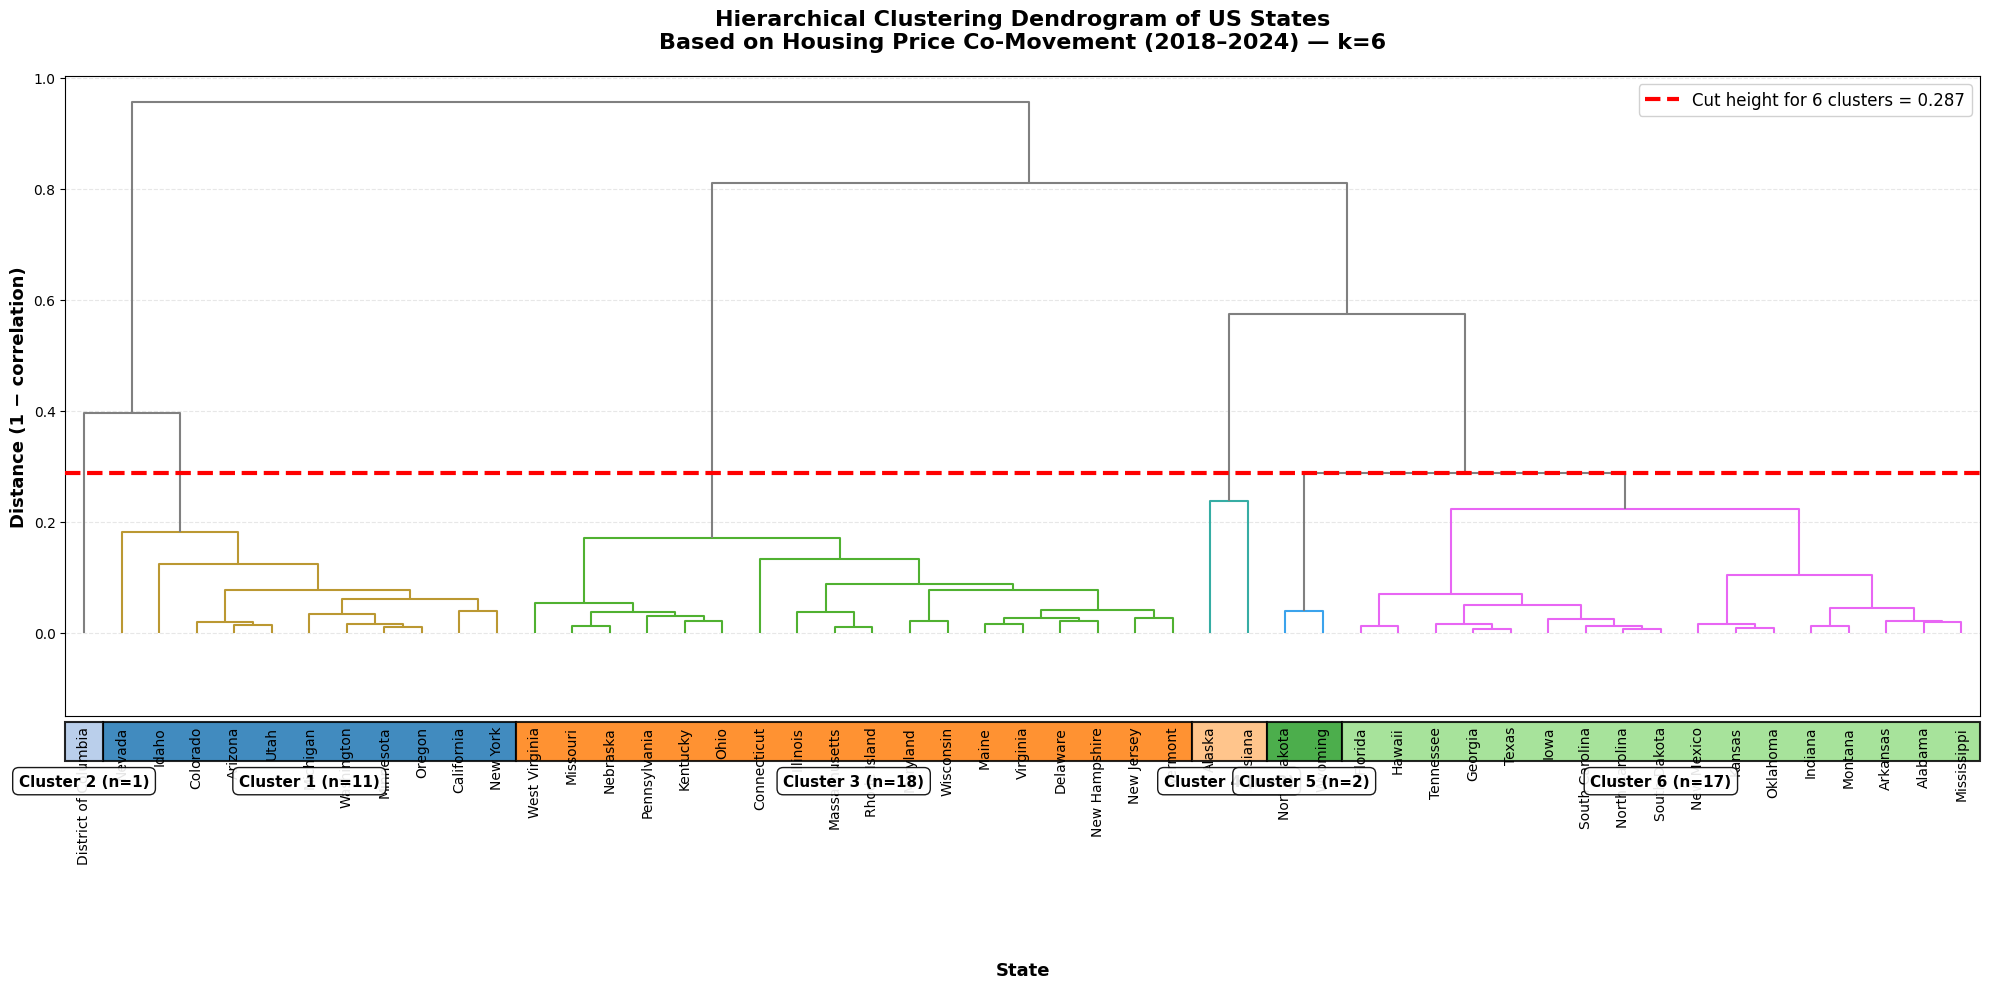

✓ Saved: viz2_dendrogram_auto_k.png


In [27]:
from scipy.cluster.hierarchy import dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# --- parameters from your run ---
# linkage_matrix: from your clustering
# correlation_matrix: pandas DataFrame with state index
# cluster_df: DataFrame with columns ['State','Cluster']
# best_k: int (chosen earlier)

fig, ax = plt.subplots(figsize=(20, 10))

# --- compute a color threshold that yields best_k clusters ---
# For n states there are n-1 merges. Cutting between the last (k-1) merges gives k clusters.
# Use a small epsilon below that merge height to ensure the dendrogram colors split correctly.
if best_k > 1:
    cut_height = float(linkage_matrix[-(best_k - 1), 2])
    color_threshold = cut_height - 1e-9
else:
    cut_height = np.inf
    color_threshold = np.inf

# --- draw dendrogram ---
dendro = dendrogram(
    linkage_matrix,
    labels=correlation_matrix.index.tolist(),
    ax=ax,
    leaf_font_size=10,
    leaf_rotation=90,
    color_threshold=color_threshold,   # dynamic
    above_threshold_color='gray'
)

# red dashed cut line at the chosen height
if np.isfinite(cut_height):
    ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=3,
               label=f'Cut height for {best_k} clusters = {cut_height:.3f}', zorder=10)

# --- figure out leaf positions and cluster spans on the x-axis ---
# SciPy places leaves at x = 5, 15, 25, ... (step = 10, offset = 5)
leaf_step, leaf_offset = 10.0, 5.0
leaf_order = dendro['leaves']                              # indices into correlation_matrix.index
state_labels = [correlation_matrix.index[i] for i in leaf_order]
leaf_x = {state: (i * leaf_step + leaf_offset) for i, state in enumerate(state_labels)}

# collect x-positions for each cluster id
cluster_ranges = {}
for cid, grp in cluster_df.groupby('Cluster'):
    xs = [leaf_x[s] for s in grp['State'] if s in leaf_x]
    if xs:
        cluster_ranges[int(cid)] = (min(xs), max(xs), len(xs))   # (start_x, end_x, count)

# --- pretty colored blocks & labels just below the leaves ---
palette = sns.color_palette("tab20", n_colors=max(12, len(cluster_ranges)))
ymin, ymax = ax.get_ylim()
band_height = (ymax - ymin) * 0.05

# transform to keep x in data coords and y in axes coords (to place boxes just below)
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

for cid in sorted(cluster_ranges.keys()):
    x0, x1, n = cluster_ranges[cid]
    color = palette[cid % len(palette)]
    # draw a band rectangle along the bottom (a tiny bit below the axis)
    ax.add_patch(plt.Rectangle(
        (x0 - leaf_step/2, -0.07),             # x in data, y in axes fraction
        (x1 - x0 + leaf_step), 0.06,           # width in data coords, height in axes fraction
        transform=trans,
        facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.85, clip_on=False
    ))
    # centered label for the cluster
    xm = (x0 + x1) / 2.0
    ax.text(xm, -0.09, f"Cluster {cid+1} (n={n})",
            transform=trans, ha='center', va='top',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='black', alpha=0.9))

# --- styling ---
ax.set_title(
    f'Hierarchical Clustering Dendrogram of US States\n'
    f'Based on Housing Price Co-Movement (2018–2024) — k={best_k}',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('State', fontsize=13, fontweight='bold', labelpad=70)
ax.set_ylabel('Distance (1 − correlation)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

if np.isfinite(cut_height):
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)

# add a bit of bottom margin for the cluster labels
ax.set_ylim(ymin - (ymax - ymin) * 0.15, ymax)
plt.tight_layout()

# save
output_dir = Path('../data/gold/zillow/q3'); output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / 'viz2_dendrogram_auto_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz2_dendrogram_auto_k.png")


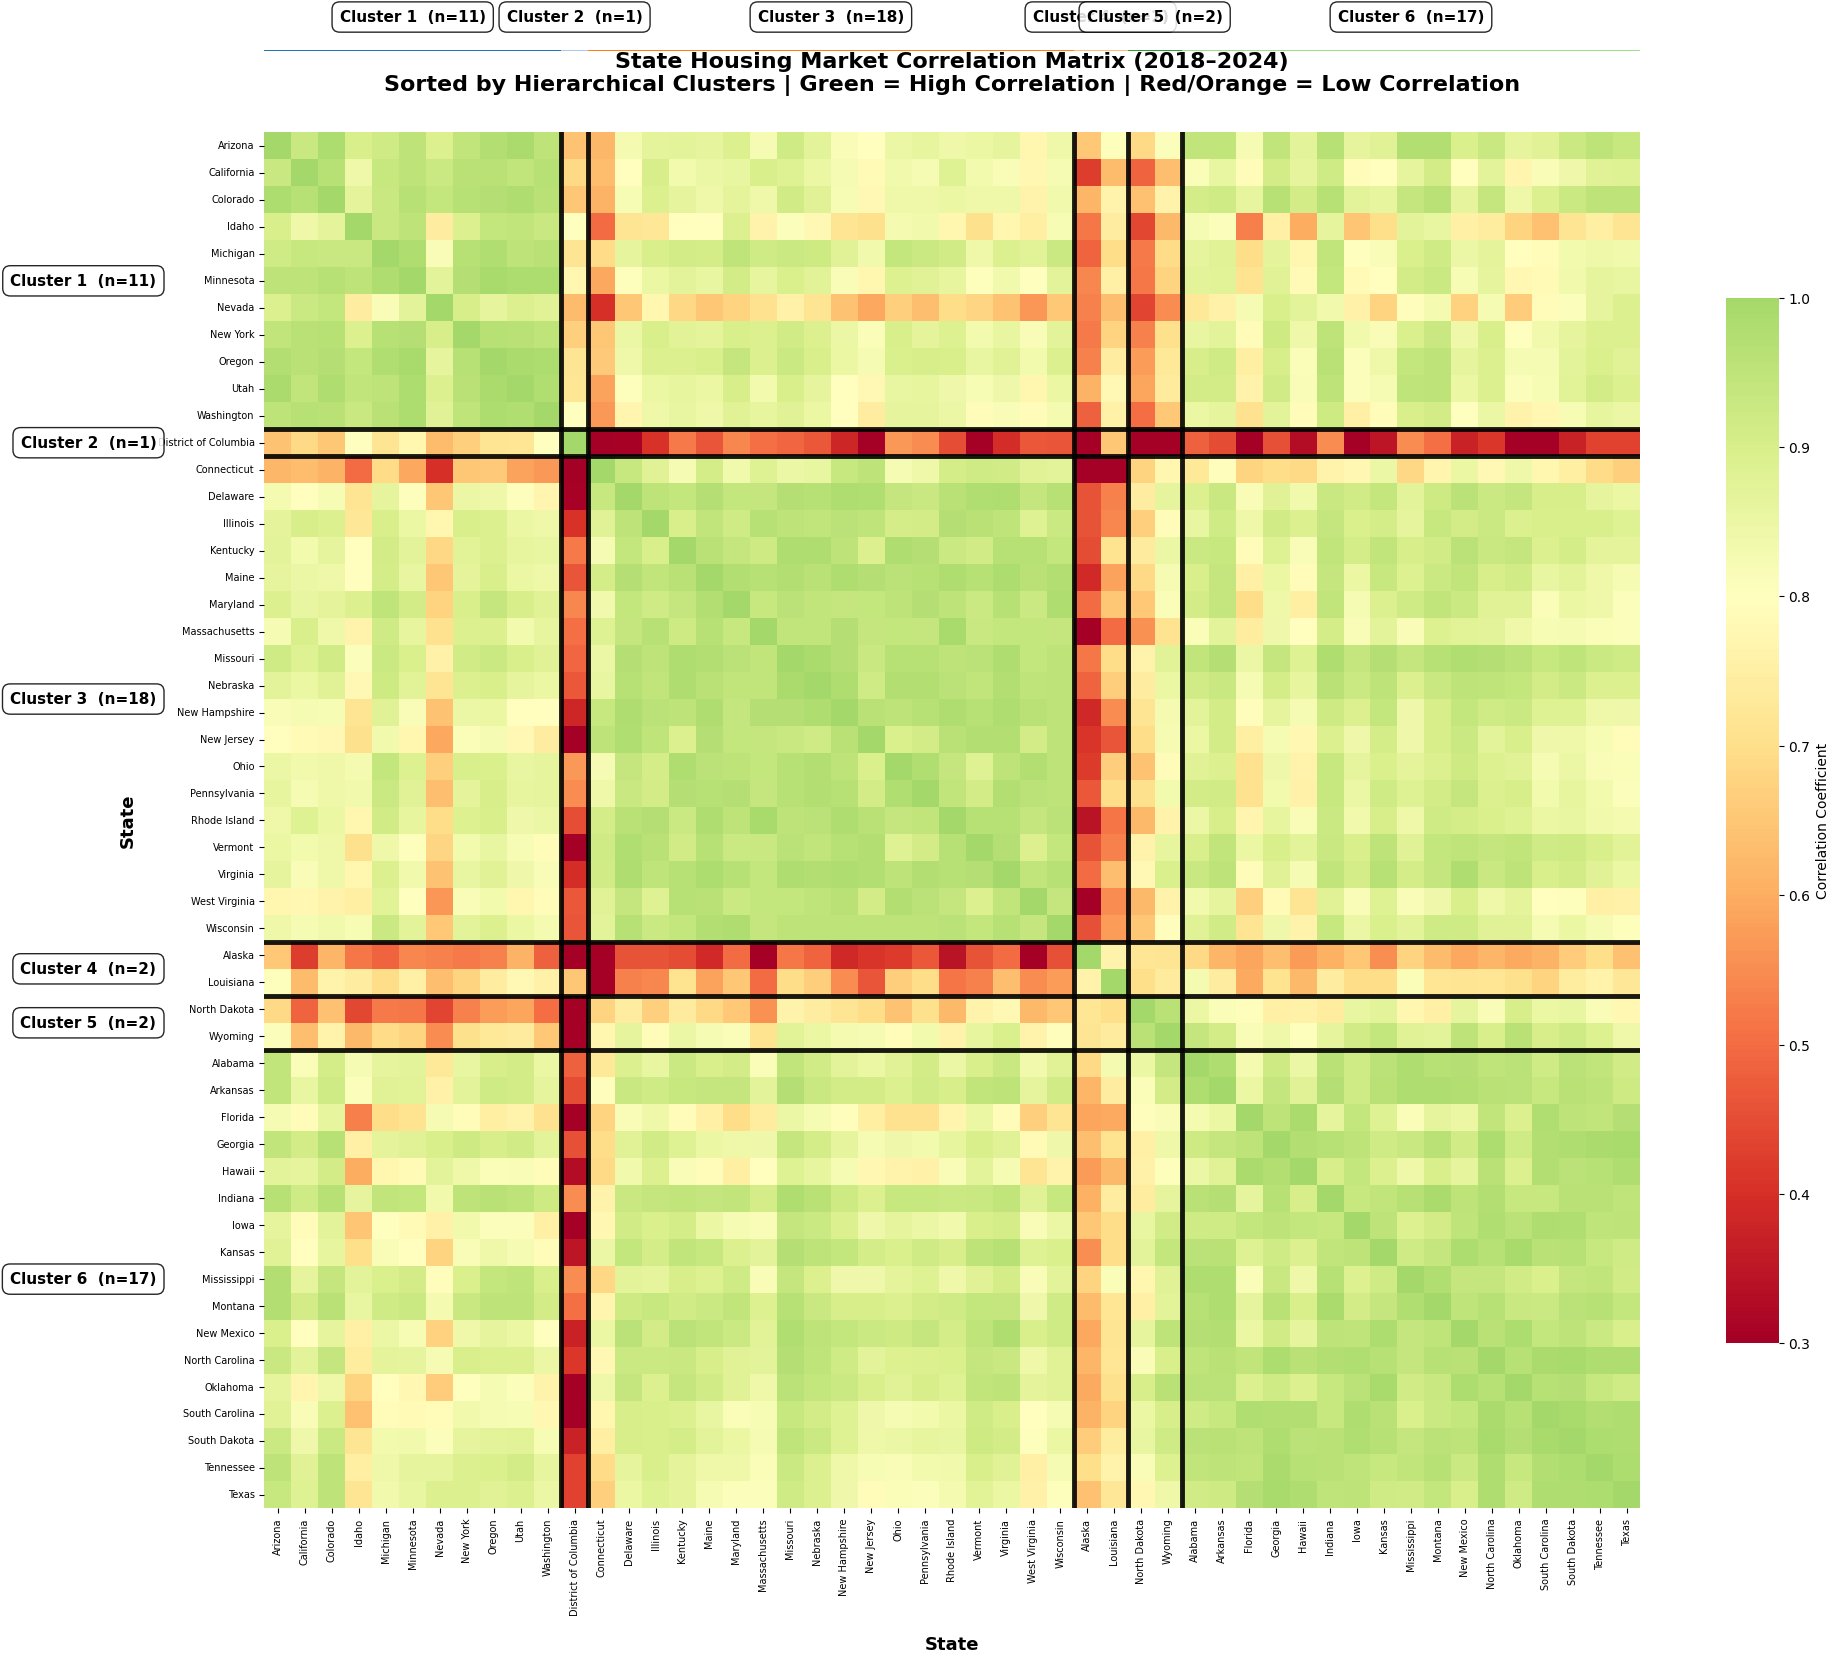

✓ Saved: ..\data\gold\zillow\q3\viz1_correlation_heatmap_auto_clusters.png


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- 0) Prep: sort states by cluster (works for any k) ---
cluster_df_sorted = cluster_df.sort_values(['Cluster','State']).reset_index(drop=True)
state_order = cluster_df_sorted['State'].tolist()
clusters_order = cluster_df_sorted['Cluster'].tolist()

# Reorder correlation matrix
corr_sorted = correlation_matrix.loc[state_order, state_order]

# Get cluster block boundaries (start, end, label)
blocks = []
for cid, g in cluster_df_sorted.groupby('Cluster', sort=True):
    start = g.index.min()
    end   = g.index.max()
    blocks.append((cid, start, end, len(g)))

# --- 1) Figure & main heatmap ---
fig, ax = plt.subplots(figsize=(20, 18))

hm = sns.heatmap(
    corr_sorted,
    cmap='RdYlGn',
    vmin=0.3, vmax=1.0,
    center=0.8,
    square=True,
    linewidths=0,
    cbar_kws={"shrink": 0.7, "label": "Correlation Coefficient"},
    xticklabels=state_order,
    yticklabels=state_order,
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,  fontsize=7, va='center')

# --- 2) Draw thick boundaries around each cluster block ---
for _, start, end, _ in blocks[:-1]:
    pos = end + 1  # grid line after the block
    ax.axhline(y=pos, color='black', linewidth=3.5, alpha=0.9)
    ax.axvline(x=pos, color='black', linewidth=3.5, alpha=0.9)

# --- 3) Add color bands for clusters (top and left) ---
# palette: distinct colors per cluster (repeat if k>12)
palette = sns.color_palette("tab20", n_colors=max(12, len(blocks)))

# Top band (an inset axis above the heatmap)
top_band = inset_axes(ax, width="100%", height="1.2%", loc='upper center',
                      bbox_to_anchor=(0, 1.01, 1, 0.05), bbox_transform=ax.transAxes, borderpad=0)
top_band.set_axis_off()

# Left band (an inset axis to the left of the heatmap)
left_band = inset_axes(ax, width="1.2%", height="100%", loc='center left',
                       bbox_to_anchor=(-0.015, 0, 0.05, 1), bbox_transform=ax.transAxes, borderpad=0)
left_band.set_axis_off()

for i, (cid, start, end, n) in enumerate(blocks):
    color = palette[cid % len(palette)]
    # top band rect
    top_band.add_patch(Rectangle((start, 0), end - start + 1, 1, facecolor=color, edgecolor='none'))
    # left band rect
    left_band.add_patch(Rectangle((0, start), 1, end - start + 1, facecolor=color, edgecolor='none'))

# Set band limits to align with heatmap grid
top_band.set_xlim(0, corr_sorted.shape[1])
top_band.set_ylim(0, 1)
left_band.set_xlim(0, 1)
left_band.set_ylim(0, corr_sorted.shape[0])

# --- 4) Place cluster labels (auto text, no overlap) ---
for cid, start, end, n in blocks:
    mid = (start + end) / 2
    label = f"Cluster {cid+1}  (n={n})"
    # Left side label
    ax.text(-4, mid + 0.5, label, fontsize=11, fontweight='bold',
            va='center', ha='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.85))
    # Top label (horizontal)
    ax.text(mid + 0.5, -4, label, fontsize=11, fontweight='bold',
            va='bottom', ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.85))

# --- 5) Title, axes labels, layout ---
ax.set_title(
    'State Housing Market Correlation Matrix (2018–2024)\n'
    'Sorted by Hierarchical Clusters | Green = High Correlation | Red/Orange = Low Correlation',
    fontsize=16, fontweight='bold', pad=30
)
ax.set_xlabel('State', fontsize=13, fontweight='bold', labelpad=15)
ax.set_ylabel('State', fontsize=13, fontweight='bold', labelpad=15)

plt.subplots_adjust(left=0.12, right=0.98, top=0.93, bottom=0.10)

# --- 6) Save & show ---
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
output_dir.mkdir(parents=True, exist_ok=True)
out_path = output_dir / 'viz1_correlation_heatmap_auto_clusters.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {out_path}")


Creating Visualization 3: Between-Cluster Correlation Matrix (auto-k, unbiased diagonal)…


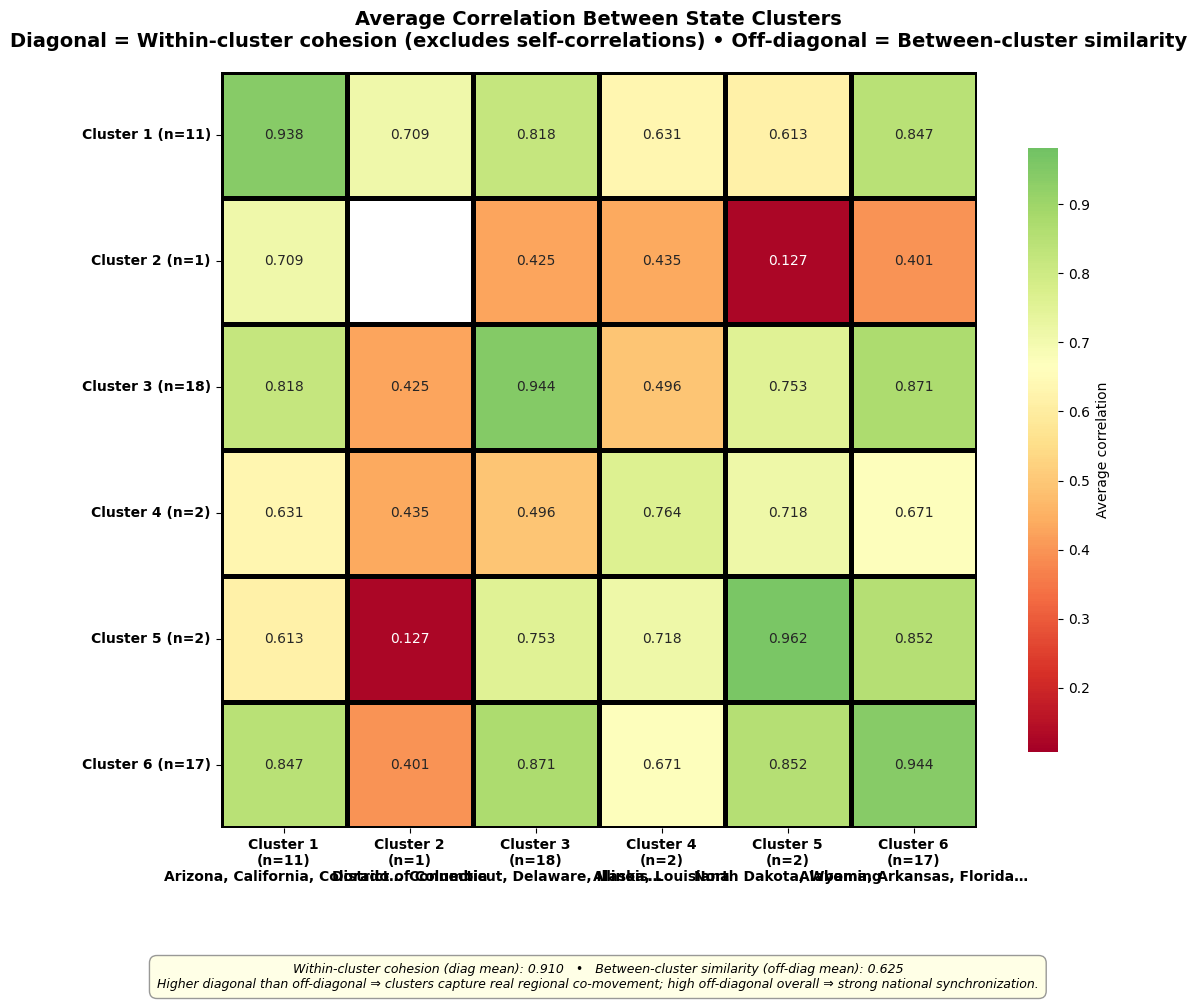

✓ Saved: ..\data\gold\zillow\q3\viz3_between_cluster_correlation.png

Between-Cluster Correlation Matrix:
       C1     C2     C3     C4     C5     C6
C1  0.938  0.709  0.818  0.631  0.613  0.847
C2  0.709    NaN  0.425  0.435  0.127  0.401
C3  0.818  0.425  0.944  0.496  0.753  0.871
C4  0.631  0.435  0.496  0.764  0.718  0.671
C5  0.613  0.127  0.753  0.718  0.962  0.852
C6  0.847  0.401  0.871  0.671  0.852  0.944


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

print("Creating Visualization 3: Between-Cluster Correlation Matrix (auto-k, unbiased diagonal)…")

# --- build cluster -> state list (sorted for stability) ---
clusters = []
for cid, g in cluster_df.groupby("Cluster", sort=True):
    states = sorted(g["State"].tolist())
    clusters.append((int(cid), states))

k = len(clusters)
between_corr_matrix = np.zeros((k, k), dtype=float)

# --- fill matrix ---
for i, (_, states_i) in enumerate(clusters):
    for j, (_, states_j) in enumerate(clusters):
        sub = correlation_matrix.loc[states_i, states_j].values
        if i == j:
            # within-cluster cohesion: mean of upper triangle EXCLUDING diagonal
            if sub.shape[0] >= 2:
                mask = np.triu(np.ones(sub.shape, dtype=bool), k=1)
                vals = sub[mask]
                between_corr_matrix[i, j] = float(vals.mean()) if vals.size else np.nan
            else:
                between_corr_matrix[i, j] = np.nan
        else:
            between_corr_matrix[i, j] = float(sub.mean())

# --- dynamic labels: "Cluster x (n=yy) — e.g., CA, TX, …" ---
def label_for(states, idx):
    n = len(states)
    ex = ", ".join(states[:3]) + ("…" if n > 3 else "")
    return f"Cluster {idx+1}\n(n={n})\n{ex}"

xticklabels = [label_for(states, i) for i, (_, states) in enumerate(clusters)]
yticklabels = [f"Cluster {i+1} (n={len(states)})" for i, (_, states) in enumerate(clusters)]

# --- heatmap scaling (avoid hard-coded center/vmin/vmax) ---
valid_vals = between_corr_matrix[~np.isnan(between_corr_matrix)]
vmin = max(0.0, valid_vals.min() - 0.02)
vmax = min(1.0, valid_vals.max() + 0.02)
center = float(valid_vals.mean())

# --- plot ---
fig, ax = plt.subplots(figsize=(min(12, 2 + 2.0*k), min(10, 1.5 + 1.5*k)))

sns.heatmap(
    between_corr_matrix,
    annot=True, fmt=".3f",
    cmap="RdYlGn",
    vmin=vmin, vmax=vmax, center=center,
    square=True,
    linewidths=2.5, linecolor="black",
    cbar_kws={"label": "Average correlation", "shrink": 0.8},
    ax=ax
)

ax.set_xticklabels(xticklabels, fontsize=10, fontweight="bold", rotation=0, ha="center")
ax.set_yticklabels(yticklabels, fontsize=10, fontweight="bold", rotation=0, va="center")

ax.set_title(
    "Average Correlation Between State Clusters\n"
    "Diagonal = Within-cluster cohesion (excludes self-correlations) • Off-diagonal = Between-cluster similarity",
    fontsize=14, fontweight="bold", pad=18
)

# brief auto-insights
diag_mean = np.nanmean(np.diag(between_corr_matrix))
off_vals = between_corr_matrix[~np.eye(k, dtype=bool)]
off_mean = float(off_vals.mean()) if off_vals.size else np.nan
note = (
    f"Within-cluster cohesion (diag mean): {diag_mean:.3f}   •   "
    f"Between-cluster similarity (off-diag mean): {off_mean:.3f}\n"
    "Higher diagonal than off-diagonal ⇒ clusters capture real regional co-movement; "
    "high off-diagonal overall ⇒ strong national synchronization."
)
fig.text(0.5, 0.02, note, ha="center", fontsize=9, style="italic",
         bbox=dict(boxstyle="round,pad=0.6", facecolor="lightyellow", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)

# save
output_dir = Path("../data/gold/zillow/q3"); output_dir.mkdir(parents=True, exist_ok=True)
outpath = output_dir / "viz3_between_cluster_correlation.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved:", outpath)

# pretty print
print("\nBetween-Cluster Correlation Matrix:")
print("="*60)
print(pd.DataFrame(between_corr_matrix,
                   index=[f"C{i+1}" for i in range(k)],
                   columns=[f"C{i+1}" for i in range(k)]).round(3))
print("="*60)


Creating Visualization 4: Cluster Summary Dashboard (NO-OVERLAP)…


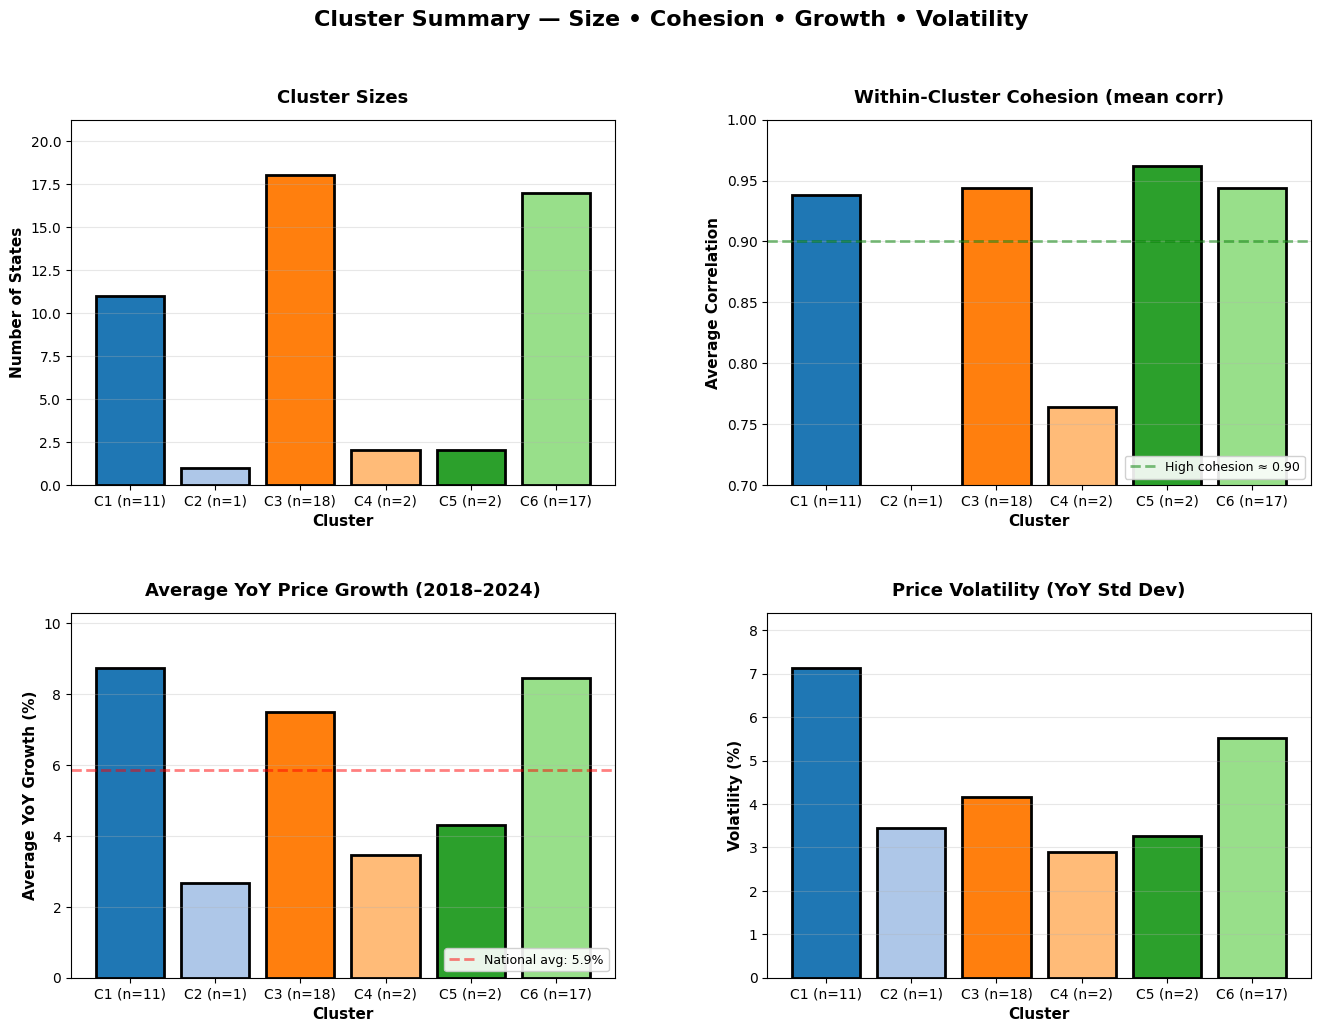

✓ Saved: ..\data\gold\zillow\q3\viz4_risk_return_clean.png


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

print("Creating Visualization 4: Cluster Summary Dashboard (NO-OVERLAP)…")

# Build cluster -> states mapping (sorted for stability)
clusters = []
for cid, g in cluster_df.groupby("Cluster", sort=True):
    states = sorted(g["State"].tolist())
    clusters.append((int(cid), states))

best_k = len(clusters)

# ---- compute stats per cluster ----
cluster_stats = []
for cid, states in clusters:
    # Within-cluster correlation: mean of upper triangle, exclude diagonal; NaN-safe
    sub = correlation_matrix.loc[states, states].to_numpy(float)
    if sub.shape[0] >= 2:
        mask = np.triu(np.ones(sub.shape, dtype=bool), k=1)
        vals = sub[mask]
        within_corr = float(np.nanmean(vals)) if vals.size else np.nan
    else:
        within_corr = np.nan

    # Average YoY growth (%). price_matrix_clean should already be YoY decimal.
    growth_vals = price_matrix_clean[states].to_numpy(float) * 100.0
    avg_growth = float(np.nanmean(growth_vals))

    # Volatility = std of YoY (%) per state, then average across states
    vol_per_state = np.nanstd(growth_vals, axis=0) if growth_vals.ndim == 2 else np.nan
    volatility = float(np.nanmean(vol_per_state))

    cluster_stats.append({
        "cluster": cid,
        "n_states": len(states),
        "within_corr": within_corr,
        "avg_growth": avg_growth,
        "volatility": volatility,
    })

# ---- short labels & colors ----
labels = [f"C{i+1} (n={s['n_states']})" for i, s in enumerate(cluster_stats)]
palette = sns.color_palette("tab20", n_colors=max(12, best_k))
colors = [palette[i % len(palette)] for i in range(best_k)]

# ---- vectors ----
sizes     = [s["n_states"]    for s in cluster_stats]
cohesions = [s["within_corr"] for s in cluster_stats]
growths   = [s["avg_growth"]  for s in cluster_stats]
vols      = [s["volatility"]  for s in cluster_stats]

# Toggle bar value labels (set to True if you want numbers back)
SHOW_VALUES = False

# ---- figure ----
fig = plt.figure(figsize=(16, 11))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.28)

def set_cluster_xticks(ax):
    pos = np.arange(1, best_k + 1)
    ax.set_xticks(pos)
    ax.set_xticklabels(labels, fontsize=10)

def maybe_bar_labels(ax, bars, fmt="{:.1f}", pad=0.03):
    if not SHOW_VALUES:
        return
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + (abs(h) * pad if h != 0 else 0.02),
            fmt.format(h),
            ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

# 1) Cluster Sizes
ax1 = fig.add_subplot(gs[0, 0])
b1 = ax1.bar(range(1, best_k+1), sizes, color=colors, edgecolor="black", linewidth=2)
ax1.set_title("Cluster Sizes", fontsize=13, fontweight="bold", pad=12)
ax1.set_xlabel("Cluster", fontsize=11, fontweight="bold")
ax1.set_ylabel("Number of States", fontsize=11, fontweight="bold")
set_cluster_xticks(ax1)
ax1.set_ylim(0, max(sizes) * 1.18)
ax1.grid(axis="y", alpha=0.3)
maybe_bar_labels(ax1, b1, fmt="{:.0f}")

# 2) Within-Cluster Cohesion
ax2 = fig.add_subplot(gs[0, 1])
b2 = ax2.bar(range(1, best_k+1), cohesions, color=colors, edgecolor="black", linewidth=2)
ax2.set_title("Within-Cluster Cohesion (mean corr)", fontsize=13, fontweight="bold", pad=12)
ax2.set_xlabel("Cluster", fontsize=11, fontweight="bold")
ax2.set_ylabel("Average Correlation", fontsize=11, fontweight="bold")
set_cluster_xticks(ax2)
# dynamic y-range (clamped to [0,1])
ymin = max(0.0, min(np.nanmin(cohesions) - 0.05, 0.7))
ymax = min(1.0, max(np.nanmax(cohesions) + 0.05, 0.9))
ax2.set_ylim(ymin, ymax)
ax2.axhline(y=0.90, color="green", linestyle="--", alpha=0.5, linewidth=2, label="High cohesion ≈ 0.90")
ax2.legend(fontsize=9, loc="lower right", framealpha=0.9)
ax2.grid(axis="y", alpha=0.3)
maybe_bar_labels(ax2, b2, fmt="{:.3f}", pad=0.012)

# 3) Average Price Growth
ax3 = fig.add_subplot(gs[1, 0])
b3 = ax3.bar(range(1, best_k+1), growths, color=colors, edgecolor="black", linewidth=2)
ax3.set_title("Average YoY Price Growth (2018–2024)", fontsize=13, fontweight="bold", pad=12)
ax3.set_xlabel("Cluster", fontsize=11, fontweight="bold")
ax3.set_ylabel("Average YoY Growth (%)", fontsize=11, fontweight="bold")
set_cluster_xticks(ax3)
ax3.set_ylim(0, max(growths) * 1.18)
ax3.grid(axis="y", alpha=0.3)
nat_avg = float(np.nanmean(growths))
ax3.axhline(y=nat_avg, color="red", linestyle="--", alpha=0.5, linewidth=2, label=f"National avg: {nat_avg:.1f}%")
ax3.legend(fontsize=9, loc="lower right", framealpha=0.9)
maybe_bar_labels(ax3, b3, fmt="{:.1f}%")

# 4) Volatility
ax4 = fig.add_subplot(gs[1, 1])
b4 = ax4.bar(range(1, best_k+1), vols, color=colors, edgecolor="black", linewidth=2)
ax4.set_title("Price Volatility (YoY Std Dev)", fontsize=13, fontweight="bold", pad=12)
ax4.set_xlabel("Cluster", fontsize=11, fontweight="bold")
ax4.set_ylabel("Volatility (%)", fontsize=11, fontweight="bold")
set_cluster_xticks(ax4)
ax4.set_ylim(0, max(vols) * 1.18)
ax4.grid(axis="y", alpha=0.3)
maybe_bar_labels(ax4, b4, fmt="{:.1f}%")

plt.suptitle("Cluster Summary — Size • Cohesion • Growth • Volatility",
             fontsize=16, fontweight="bold", y=0.98)

# a touch more bottom margin so ticks never collide
plt.tight_layout()
plt.subplots_adjust(bottom=0.10)

outdir = Path("../data/gold/zillow/q3"); outdir.mkdir(parents=True, exist_ok=True)
outpath = outdir / "viz4_risk_return_clean.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved:", outpath)


Creating SIMPLE Risk-Return Chart (auto-k, clean)…


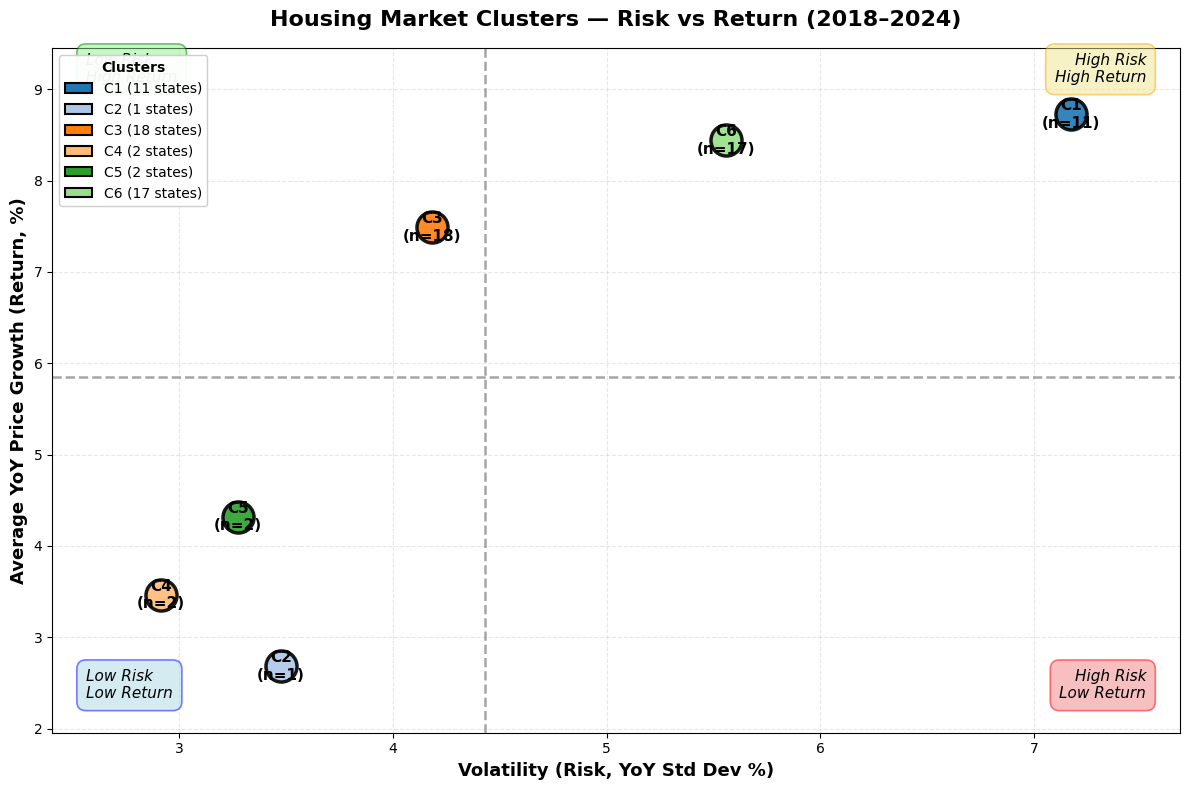


CLUSTER POSITIONING (vs mean risk/return):
 C1: HIGH RISK, HIGH RETURN — Growth 8.7%, Vol 7.2%
 C2: LOW RISK, LOW RETURN — Growth 2.7%, Vol 3.5%
 C3: ✓ LOW RISK, HIGH RETURN — Growth 7.5%, Vol 4.2%
 C4: LOW RISK, LOW RETURN — Growth 3.5%, Vol 2.9%
 C5: LOW RISK, LOW RETURN — Growth 4.3%, Vol 3.3%
 C6: HIGH RISK, HIGH RETURN — Growth 8.4%, Vol 5.6%


In [35]:
# --- weekly aggregation block looks fine; keeping as-is ---

# === RISK vs RETURN (auto-k, no overlap) ===
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from pathlib import Path

print("Creating SIMPLE Risk-Return Chart (auto-k, clean)…")

# 1) Gather cluster stats (works for any best_k)
cluster_data = []
for cid, g in cluster_df.groupby("Cluster", sort=True):
    states = g["State"].tolist()
    avg_growth = float((price_matrix_clean[states].mean().mean()) * 100.0)
    volatility = float((price_matrix_clean[states].std().mean()) * 100.0)
    cluster_data.append({"id": int(cid), "n_states": len(states),
                         "growth": avg_growth, "volatility": volatility})

# sort by id (ensures stable color mapping)
cluster_data.sort(key=lambda d: d["id"])
best_k = len(cluster_data)

# 2) Colors & names (dynamic)
palette = plt.cm.tab20.colors  # long palette
colors = [palette[i % len(palette)] for i in range(best_k)]
cluster_names = [f"C{i+1}" for i in range(best_k)]

# 3) Compute means and plot limits with padding
xs = np.array([d["volatility"] for d in cluster_data], dtype=float)
ys = np.array([d["growth"]     for d in cluster_data], dtype=float)

xpad = (xs.max() - xs.min()) * 0.12 if xs.size else 1.0
ypad = (ys.max() - ys.min()) * 0.12 if ys.size else 1.0
xmin, xmax = xs.min() - xpad, xs.max() + xpad
ymin, ymax = ys.min() - ypad, ys.max() + ypad

xmean = float(xs.mean())
ymean = float(ys.mean())

fig, ax = plt.subplots(figsize=(12, 8))

# 4) Scatter (one marker per cluster) + inside labels
for i, d in enumerate(cluster_data):
    ax.scatter(d["volatility"], d["growth"],
               s=500, color=colors[i], edgecolor="black",
               linewidth=2.5, alpha=0.9, zorder=3)
    ax.text(d["volatility"], d["growth"],
            f"{cluster_names[i]}\n(n={d['n_states']})",
            ha="center", va="center", fontsize=11, fontweight="bold",
            zorder=4)

# 5) Quadrant lines at means
ax.axhline(y=ymean, color='gray', linestyle='--', linewidth=1.8, alpha=0.7)
ax.axvline(x=xmean, color='gray', linestyle='--', linewidth=1.8, alpha=0.7)

# 6) Corner quadrant labels in axes coordinates (no overlap with data)
ax.text(0.03, 0.95, "Low Risk\nHigh Return", transform=ax.transAxes,
        fontsize=11, style='italic', ha='left',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='lightgreen',
                  edgecolor='green', linewidth=1.2, alpha=0.5))
ax.text(0.97, 0.95, "High Risk\nHigh Return", transform=ax.transAxes,
        fontsize=11, style='italic', ha='right',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='khaki',
                  edgecolor='orange', linewidth=1.2, alpha=0.5))
ax.text(0.03, 0.05, "Low Risk\nLow Return", transform=ax.transAxes,
        fontsize=11, style='italic', ha='left',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='lightblue',
                  edgecolor='blue', linewidth=1.2, alpha=0.5))
ax.text(0.97, 0.05, "High Risk\nLow Return", transform=ax.transAxes,
        fontsize=11, style='italic', ha='right',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='lightcoral',
                  edgecolor='red', linewidth=1.2, alpha=0.5))

# 7) Legend (dynamic, non-overlapping)
legend_handles = [Patch(facecolor=colors[i], edgecolor='black', linewidth=1.5,
                        label=f"{cluster_names[i]} ({cluster_data[i]['n_states']} states)")
                  for i in range(best_k)]
leg = ax.legend(handles=legend_handles, loc='upper left', framealpha=0.95,
                title="Clusters", fontsize=10)
leg.get_title().set_fontweight('bold')

# 8) Axes, grid, limits
ax.set_xlabel('Volatility (Risk, YoY Std Dev %)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average YoY Price Growth (Return, %)', fontsize=13, fontweight='bold')
ax.set_title('Housing Market Clusters — Risk vs Return (2018–2024)',
             fontsize=16, fontweight='bold', pad=16)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()

# Save
output_dir = Path('../data/gold/zillow/q3'); output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / 'viz5_risk_return_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# 9) Console summary
print("\n" + "="*60)
print("CLUSTER POSITIONING (vs mean risk/return):")
for i, d in enumerate(cluster_data):
    if d['volatility'] < xmean and d['growth'] > ymean:
        pos = "✓ LOW RISK, HIGH RETURN"
    elif d['volatility'] >= xmean and d['growth'] > ymean:
        pos = "HIGH RISK, HIGH RETURN"
    elif d['volatility'] < xmean and d['growth'] <= ymean:
        pos = "LOW RISK, LOW RETURN"
    else:
        pos = "⚠ HIGH RISK, LOW RETURN"
    print(f" {cluster_names[i]}: {pos} — Growth {d['growth']:.1f}%, Vol {d['volatility']:.1f}%")
print("="*60)
